# Conceptual building blocks

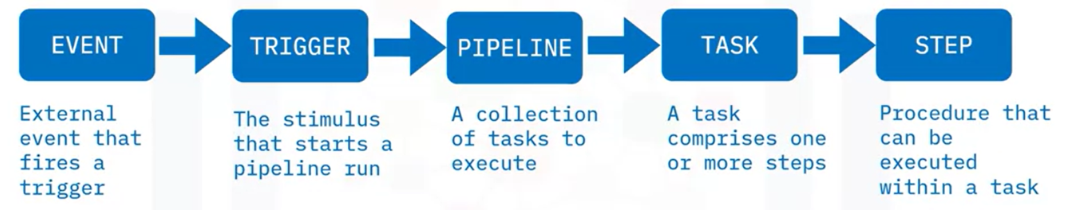

# Physical building blocks

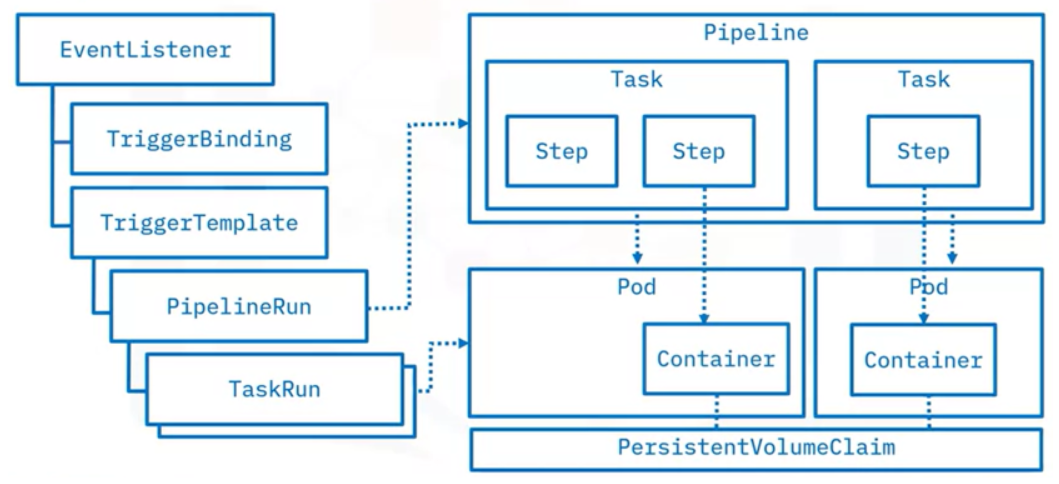

# High level Pipeline Design

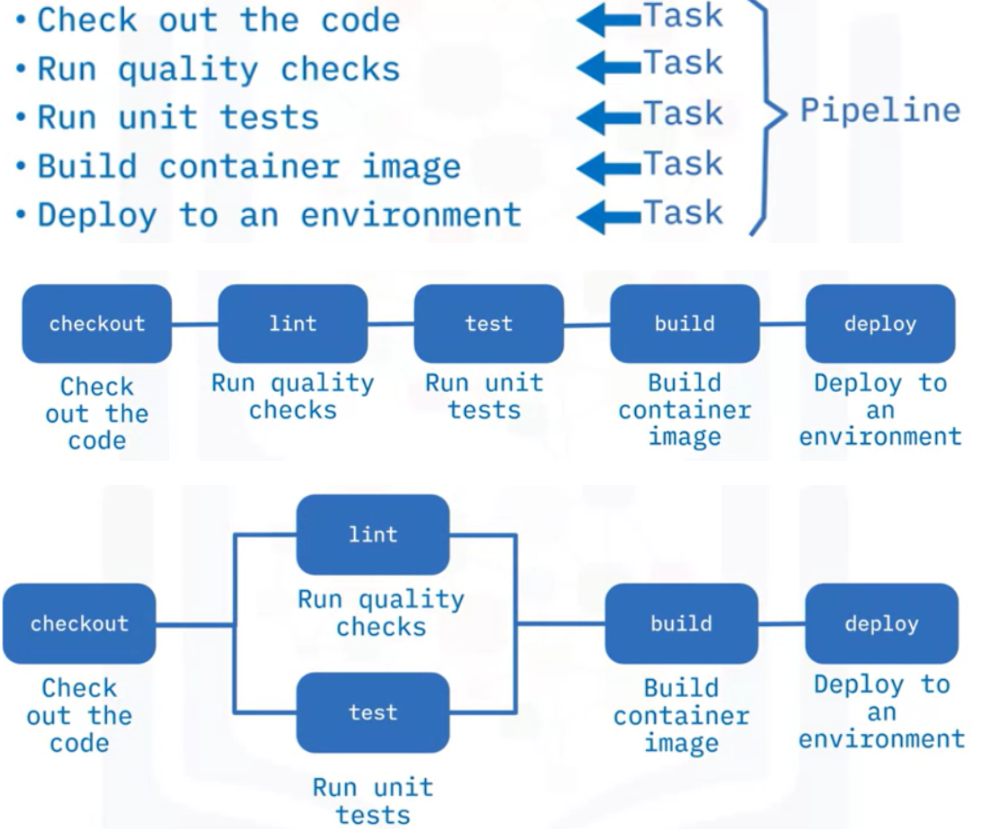

# Tekton Hub (`hub.tekton.dev`)

* Search task in Tekton Hub (`hub.tekton.dev`) **using Tekton CLI**: **`tkn hub search --kinds task TASK_NAME`** 
* Getting task information using **Tekton CLI**: **`tkn hub info task TASK_NAME`** 

> Note: `TASK_NAME` refers to the task you're looking for in Tekton Hub

Remember that **administrators can install tasks at the cluster level**.
* It's always a good idea to use the command: **`tkn clustertask ls`** to see what cluster tasks are installed.
* In this example, **TASK_NAME** is installed at the cluster level so there is no need to install it locally into your namespace.
* Anyone in the cluster can use cluster tasks in their pipelines.
* If it isn’t installed at the cluster level, you can install the **TASK_NAME** task into your local namespace using the **Tekton CLI**.
* The command is **`tkn hub install task`** followed by the name of the task you want to install, which in this case is **`TASK_NAME`**.
* You should see a result returned that indicates that **TASK_NAME** has been installed into your current namespace.


# checkout task: `checkout.yaml`

## Custom Task

```
apiVersion: tekton.dev/v1beta1
kind: Task
metadata:
  name: checkout
spec:
  params:
    - name: repo-url
      description: The URL of the git repo to clone
      type: string
    - name: branch
      description: The branch to clone
      type: string
  steps:
    - name: checkout
      image: bitnami/git:latest
      command: [git]
      args: ["clone", "--branch", "$(params.branch)", "$(params.repo-url)"]
```

**Apply the new task definition to the cluster:** `kubectl apply -f tasks.yaml`

**You should see the following output:**
```
task.tekton.dev/checkout created
```
You can now reference this task by its name `checkout` when creating **pipleline**.

## Install `git-clone` tekton task from Tekton Hub 

> **This is recomended as it is pre-biuilt and tested.**

Use this command to install the `git-clone` task from **Tekton Hub** (`hub.tekton.dev`):
```
tkn hub install task git-clone --version 0.8
```

# lint task: Install `flake8` tekton task

* Check whether the task  is installed at cluster level **(i.e. `ClusterTask`)** by administrators: **`tkn clustertask ls`**
* If not, search the task in Tekton Hub using **Tekton CLI**: **`tkn hub search --kinds task flake8`**
* To install the **`flake8`** task into your namespace using **Tekton CLI**: **`tkn hub install task flake8`**
* This will install the **`flake8`** task in your Kubernetes namespace.

# test task: `test.yaml`

```
apiVersion: tekton.dev/v1beta1
kind: Task
metadata:
  name: nose
spec:
  workspaces:
    - name: source
      workspace: pipeline-workspace
  params:
    - name: args
      description: Arguments to pass to nose
      type: string
      default: "-v"
  steps:
    - name: nosetests
      image: python:3.9-slim
      workingDir: $(workspaces.source.path)
      script: |
        #!/bin/bash
        set -e
        python -m pip install --upgrade pip wheel
        pip install -r requirements.txt
        nosetests $(params.args)
```

**Apply these changes to your cluster:** `kubectl apply -f tasks.yaml`

**You should see the following output:**
```
task.tekton.dev/nose created
```

# build task: `build.yaml`

* Check whether the task  is installed at cluster level **(i.e. `ClusterTask`)** by administrators: **`tkn clustertask ls`**
* If not, search the task in Tekton Hub using **Tekton CLI**: **`tkn hub search --kinds task build`**
* To install the **`buildah`** task into your namespace using **Tekton CLI**: **`tkn hub install task buildah`**
* This will install the **`buildah`** task in your Kubernetes namespace.

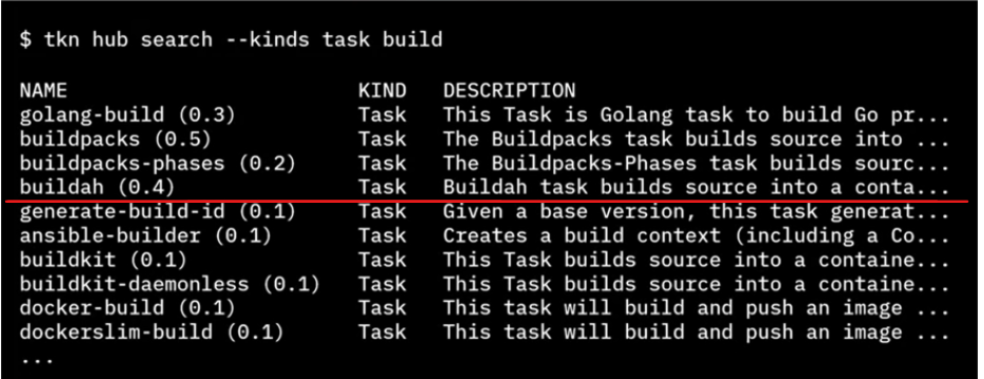

> *NOTE: The **buildah** task builds your source into a container image from a **Dockerfile** and then pushes it to a container registry using Project Atomic's Buildah build tool.*

**Install the buildah task**

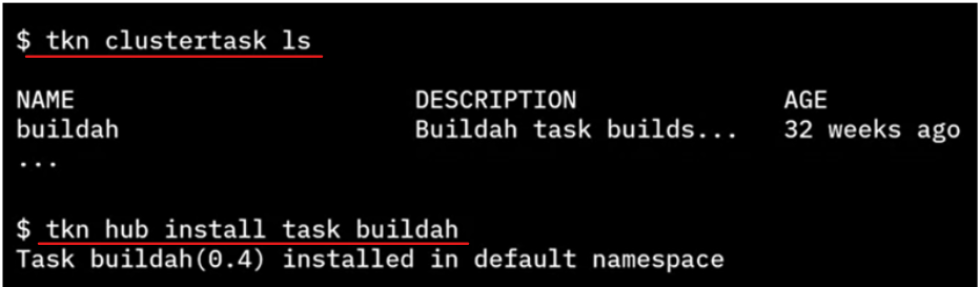

# deploy task: `deploy.yaml`

* Check whether the task  is installed at cluster level **(i.e. `ClusterTask`)** by administrators: **`tkn clustertask ls`**
* If not, search the task in Tekton Hub using **Tekton CLI**: **`tkn hub search cli`**
* To install the **`openshift-client`** task into your namespace using **Tekton CLI**: **`tkn hub install task openshift-client`**
* This will install the **`openshift-client`** task in your Kubernetes namespace.

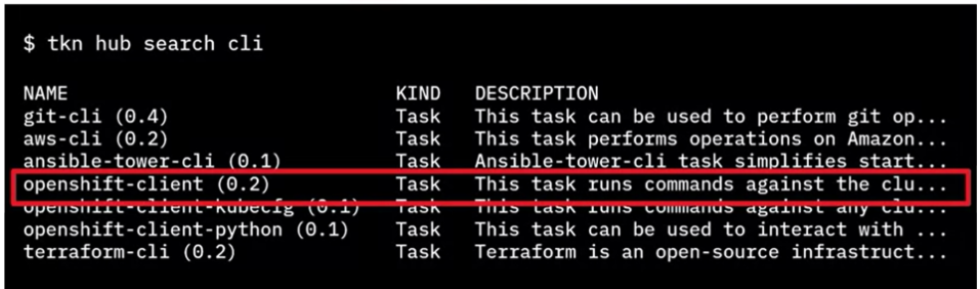

**Getting task information using Tekton CLI**

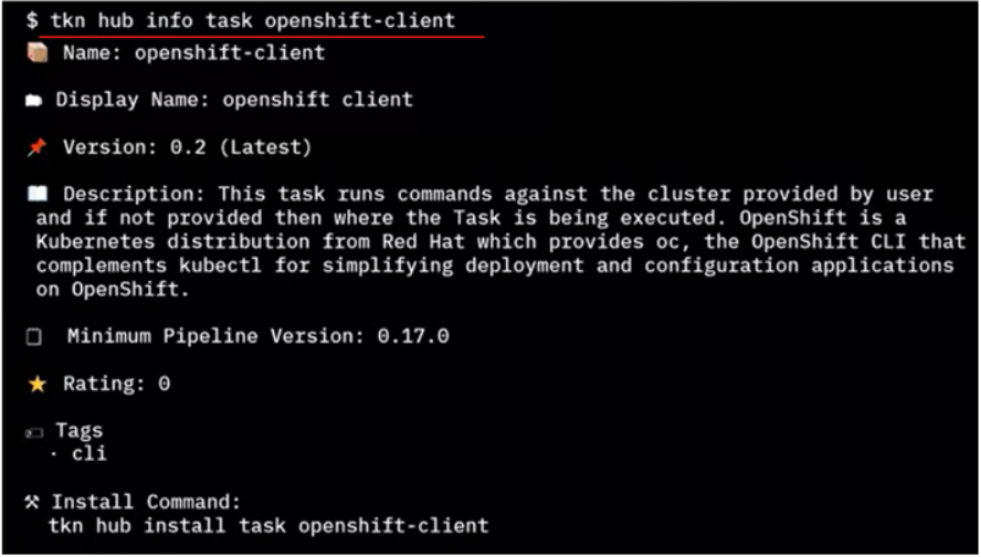

**Install the Openshift Client task**

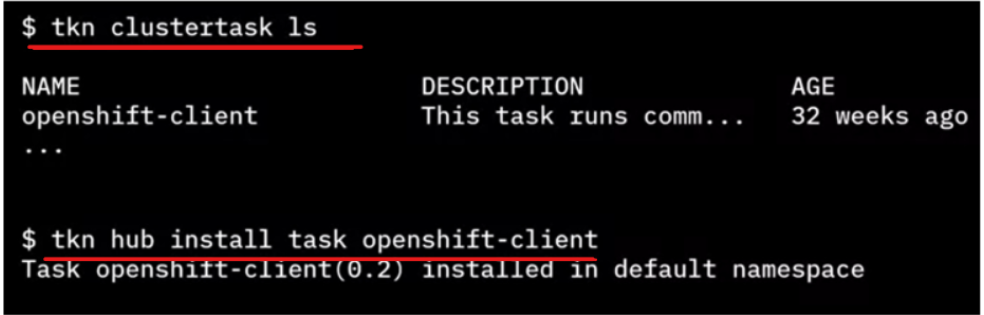

# Using environment properties: `Secret` credentials

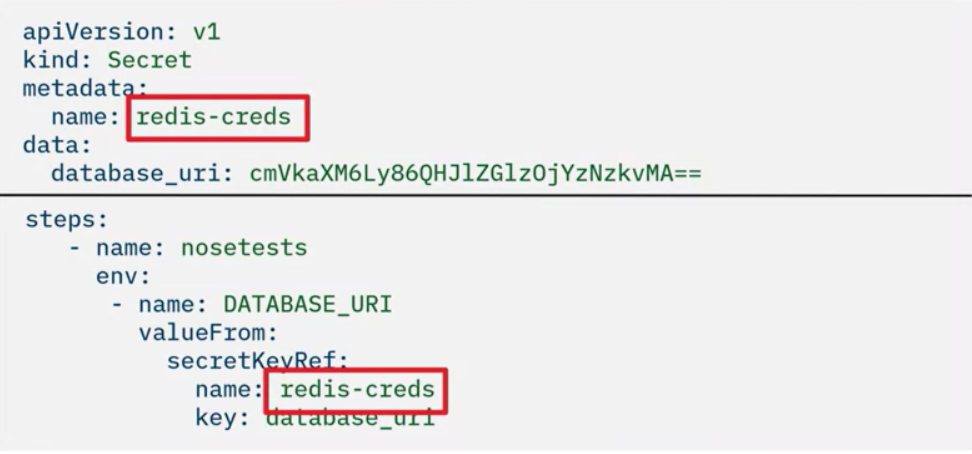

# Workspace

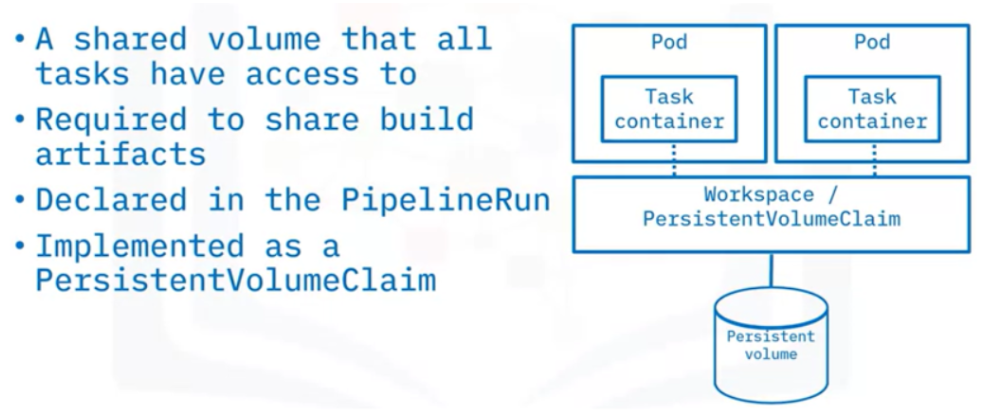

# `pvc.yaml`

```
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: pipelinerun-pvc
spec:
  storageClassName: skills-network-learner
  resources:
    requests:
      storage:  1Gi
  volumeMode: Filesystem
  accessModes:
    - ReadWriteOnce
```

**Apply the new task definition to the cluster:** `kubectl apply -f pvc.yaml`

**You should see the following output:**
```
persistentvolumeclaim/pipelinerun-pvc created
```

You can now reference this persistent volume by its name `pipelinerun-pvc` when creating workspaces for your Tekton tasks.

# `pipeline.yaml`

```
apiVersion: tekton.dev/v1beta1
kind: Pipeline
metadata:
  name: cd-pipeline
spec:
  workspaces:
    - name: pipeline-workspace
  params:
    - name: app-name
    - name: build-image
    - name: repo-url
    - name: branch
      default: master
  tasks:
    - name: clone
      workspaces:
        - name: output
          workspace: pipeline-workspace
      taskRef:
        name: checkout
      params:
      - name: url
        value: "$(params.repo-url)"
      - name: revision
        value: "$(params.branch)"

    - name: lint
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: flake8
      params:
      - name: image
        value: "python:3.9-slim"
      - name: args
        value: ["--count","--max-complexity=10","--max-line-length=127","--statistics"]
      runAfter:
        - clone

    - name: tests
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: nose
      params:
      - name: args
        value: "-v --with-spec --spec-color"
      runAfter:
        - clone

    - name: build
      workspaces:
        - name: source
          workspace: pipeline-workspace
      taskRef:
        name: buldah
        kind: ClusterTask
      params:
      - name: IMAGE
        value: "$(params.build-image)"
      runAfter:
        - tests
        - lint

    - name: deploy
      taskRef:
        name: openshift-client
        kind: ClusterTask
      params:
      - name: SCRIPT
        value: "oc create deploy $(params.app-name) --image=$(params.build-image)"
      runAfter:
        - build
```

**Apply the new task definition to the cluster:** `kubectl apply -f pipeline.yaml`

**You should see the following output:**
```
pipeline.tekton.dev/cd-pipeline created
```
You can now reference this pipeline by its name `cd-pipeline` in the **`PipelineRun`** in **TriggerTemplate**.

# Start the pipeline

When you start the pipeline, 
* You need to pass in the **`build-image`** parameter, which is the name of the image to build.
* For example: `image-registry.openshift-image-registry.svc:5000/$SN_ICR_NAMESPACE/tekton-lab:latest`
* When you start the pipeline, you now need to pass in the **`app-name`** parameter, which is the name of the application to deploy.
* Your application is called **`hitcounter`** so this is the name that you will pass in, along with all the other parameters

Now, start the pipeline to see your new build task run. Use the Tekton CLI `pipeline start` command to run the pipeline, passing in the parameters `repo-url`, `branch`, and `build-image` using the `-p` option. Specify the workspace `pipeline-workspace` and volume claim `pipelinerun-pvc` using the `-w` option:
```
tkn pipeline start cd-pipeline \
    -p repo-url="https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode.git" \
    -p branch=main \
    -p build-image=image-registry.openshift-image-registry.svc:5000/$SN_ICR_NAMESPACE/tekton-lab:latest \
    -w name=pipeline-workspace,claimName=pipelinerun-pvc \
    --showlog
```

You should see `Waiting for logs to be available...` while the pipeline runs. The logs will be shown on the screen. Wait until the pipeline run completes successfully.

# Check pipeline run status

You can see the pipeline run status by listing the pipeline runs with: **`tkn pipelinerun ls`**

**You should see:**

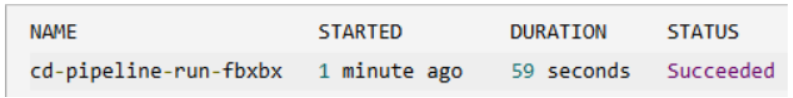

You can check the logs of the last run with: **`tkn pipelinerun logs --last`**

If it is successful, the last line you should see in the logs is: **`[deploy : oc] deployment.apps/hitcounter created`**


# Check the Deployment

Now, check to see if the deployment is running. Use the `kubectl` command to check that your deployment is in a running state.
```
kubectl get all -l app=hitcounter
```

**You should see:**

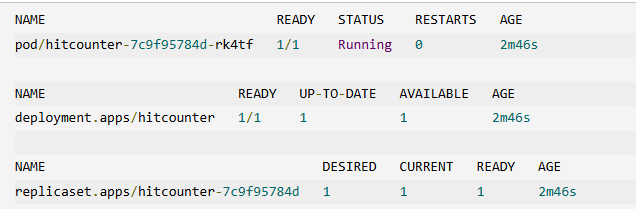

If your **pod** is running, your application has been successfully deployed.

> * ***So far we have executed the pipeline manually using `Tekton CLI`.***
> * ***Next, we will see how to setup `EventListener` which will trigger the pipeline based on events.***

# EventListener: TriggerBinding & TriggerTemplate

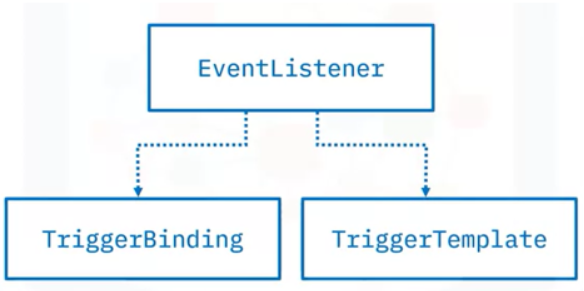

* The `TriggerBinding` CRD, which takes data from the event and binds it to the properties in your pipeline.
* The `TriggerTemplate` CRD, which takes data from the binding and instantiates a PipelineRun, passing in that data.

**Tekton triggers flow**

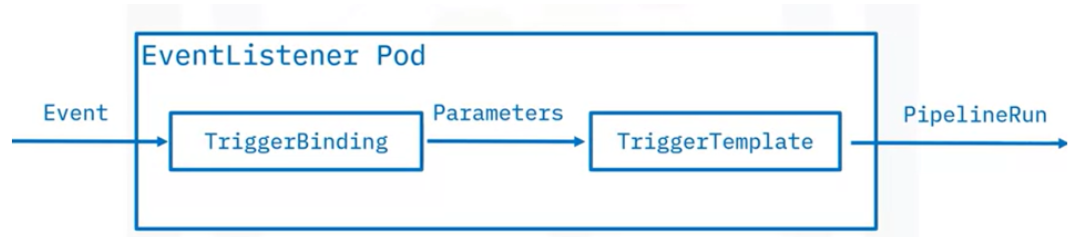

**Parameters flow**

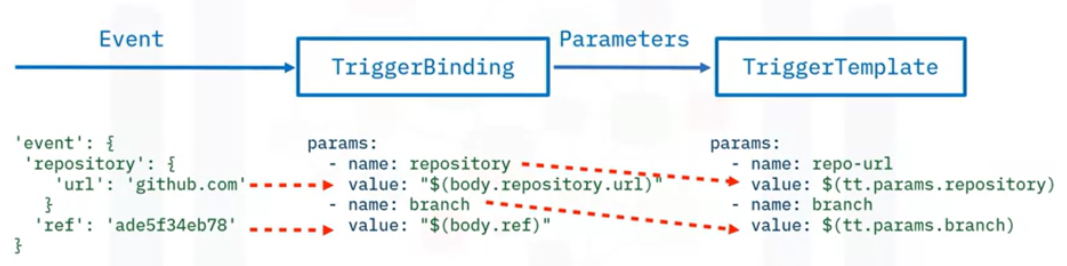

## `eventlistener.yaml`

```
apiVersion: triggers.tekton.dev/v1beta1
kind: EventListener
metadata:
  name: cd-listener
spec:
  serviceAccountName: pipeline
  triggers:
    - bindings:
      - ref: cd-binding
      template:
        ref: cd-template
```

Apply the `EventListener` resource to the cluster: **`kubectl apply -f eventlistener.yaml`**

Check that it was created correctly: **`tkn eventlistener ls`**

**You should see a reply similar to this:**

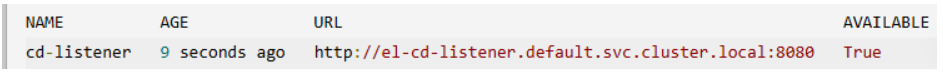

You will create the **`TriggerBinding`** named **`cd-binding`** and a **`TriggerTemplate`** named **`cd-template`** in the next steps.

## `triggerbinding.yaml`

```
apiVersion: triggers.tekton.dev/v1beta1
kind: TriggerBinding
metadata:
  name: cd-binding
spec:
  params:
    - name: repository
      value: $(body.repository.url)
    - name: branch
      value: $(body.ref)
```

Apply the new **`TriggerBinding`** definition to the cluster: **`kubectl apply -f triggerbinding.yaml`**

## `triggertemplate.yaml`

```
apiVersion: triggers.tekton.dev/v1beta1
kind: TriggerTemplate
metadata:
  name: cd-template
spec:
  params:
    - name: repository
      description: The git repo
      default: " "
    - name: branch
      description: the branch for the git repo
      default: master
  resourcetemplates:
    - apiVersion: tekton.dev/v1beta1
      kind: PipelineRun
      metadata:
        generateName: cd-pipeline-run-
      spec:
        serviceAccountName: pipeline
        pipelineRef:
          name: cd-pipeline
        workspace:
          - name: pipleline-workspace
            persistentVolumeClaim:
                claimName: pipelinerun-pvc
        params:
          - name: repo-url
            value: $(tt.params.repository)
          - name: branch
            value: $(tt.params.branch)
```

> **Note:**
> * *While the parameter you bound from the event is `repository`, you pass it on as `repo-url` to the pipeline. This is to show that the names do not have to match, allowing you to use any pipeline to map parameters into.*
> * *You have reference the persistent volume by its name `pipelinerun-pvc` while creating `PipelineRun` defined in `triggertemplate.yaml`*

Apply the new TriggerTemplate definition to the cluster: **`kubectl apply -f triggertemplate.yaml`**

## Start a Pipeline Run

### Terminal 1:


`Port Forwarding to expose a port for the eventListener to listen to external request`.

**Use the `kubectl port-forward` command to forward port `8090` to `8080`**.

```
kubectl port-forward service/el-cd-listener  8090:8080
```

**You will see the following output, but you will not get your cursor back.**

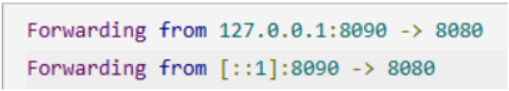

### Terminal 2: 


**Use the `curl` command to send a payload to the event listener service**

```
curl -X POST http://localhost:8090 \
  -H 'Content-Type: application/json' \
  -d '{"ref":"main","repository":{"url":"https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode"}}'
```

**This should start a `PipelineRun`.** 

**You can check on the status with this command:** `tkn pipelinerun ls`

**You should see something like this come back:**

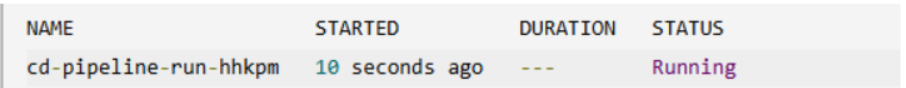

You can also examine the `PipelineRun` logs using this command (the `-L` means **"latest"** so that you do not have to look up the name for the last run): 

```
tkn pipelinerun logs --last
```

**You should see:**

```
[clone : checkout] Cloning into 'wtecc-CICD_PracticeCode'...

[lint : echo-message] Calling Flake8 linter...

[tests : echo-message] Running unit tests with PyUnit...

[build : echo-message] Building image for https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode ...

[deploy : echo-message] Deploying master branch of https://github.com/ibm-developer-skills-network/wtecc-CICD_PracticeCode ...
```